# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: This notebook will do some clustering and classification on the recipes missing cuisine labels. Make this fast and see what we can get. Then move on to:

1. Fixing Render
2. Creating login system to store searches and preferences
3. Fixing the filtering
4. Working on scrapers
5. Working on the database

### Author: Aaron Chen


---

### If needed, run shell commands here

In [1]:
# !python -m spacy download en_core_web_sm
# !python -c "import tkinter"

---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [2]:
# from bokeh.plotting import figure, output_file, save, show
# from bokeh.io import output_notebook
import DBCV
import hdbscan
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import optuna
import pandas as pd
from scipy.spatial.distance import euclidean
import seaborn as sns
# from sklearn.cluster import FeatureAgglomeration, KMeans
from sklearn.decomposition import NMF
# from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split


---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [3]:
import project_path

import src.dataframe_preprocessor as dfpp
import src.nlp_processor as nlp_proc
import src.plotter as ILoveMyKeyboard
import src.transformers as skt

%matplotlib inline

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---

## Define global variables 
### Remember to refactor these out, not ideal

In [4]:
# output_notebook()

---

## Running Commentary

1. 

### To Do

1. 

---

## Importing and viewing the data as a dataframe

In [5]:
raw_data_path = '../../data/recipes-en-201706/epicurious-recipes_m2.json'

joblib_basepath = '../../joblib/2022.08.23/'

cv_path = joblib_basepath + 'countvec.joblib'
tfidf_path = joblib_basepath + 'tfidf.joblib'
full_df_path = joblib_basepath + 'recipes_with_cv.joblib'
reduced_df_path = joblib_basepath + 'reduced_df.joblib'
rfc_path = joblib_basepath + 'rfc_clf.joblib'
X_path = joblib_basepath + 'X.joblib'
y_path = joblib_basepath + 'y.joblib'
truncSVD_path = joblib_basepath + 'truncSVD.joblib'
truncSVD_transformed_path = joblib_basepath + 'truncSVD_transformed.joblib'
svd_numpy_path = joblib_basepath + 'SVD_numpy.joblib'
to_plot_path = joblib_basepath + 'to_plot.joblib'
tsne_path = joblib_basepath + 'tsne.joblib'
tsne_vis_path = joblib_basepath + 'tsne_vis.joblib'
kmeans_path = joblib_basepath + 'kmeans.joblib'

Let's get Optuna working with HDBSCAN and DBCV.

Seems like the idea is to maximize the DBCV score.

In [6]:
cv = load(cv_path)
tfidf = load(tfidf_path)
recipes_with_cv = load(full_df_path)
recipes_with_cv.set_index('id', inplace=True, drop=True)
reduced_df = load(reduced_df_path)
reduced_df.set_index('id', inplace=True, drop=True)
rfc_clf = load(rfc_path)
X = load(X_path)
y = load(y_path)

In [29]:
recipes_with_cv

,dek,hed,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,cuisine_name,photo_filename,photo_credit,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,Missing Cuisine,51247610_fried-chicken_1x1.jpg,Michael Graydon and Nikole Herriott,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,Italian,EP_12162015_placeholders_rustic.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,Kosher,EP_09022015_honeycake-2.jpg,"Photo by Chelsea Kyle, Food Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,Kosher,EP_12162015_placeholders_casual.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,Kosher,EP_12162015_placeholders_formal.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,0.00,"[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",0,0,Missing Cuisine,waffle-ham-and-cheese-melt-062817.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,0.00,"[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,0,0,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,0.00,"[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,0,0,Missing Cuisine,waffle-mac-n-cheese-062816.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=240, stratify=y
    )

In [8]:
X_train

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a4638719925f464b395c16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a441126529d92b2c01b5f2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a409bb19925f464b37380a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a42e1019925f464b3818d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54a436266529d92b2c018767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a466e16529d92b2c026f67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a451cd6529d92b2c01eefd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Defining our trial (Optuna)

In [12]:
def objective(trial):
    cluster_size = trial.suggest_int('min_cluster_size', 10, 200)
    min_samps = trial.suggest_int('min_samples', 5, 60)
    cluster_selection_eps = trial.suggest_float('cluster_selection_epsilon', 0.2, 0.7)

    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_samps, cluster_selection_epsilon=cluster_selection_eps)

    hdbscan_labels = hdbscanner.fit_predict(X_train.values)

    # DBCV is actually built into HDBSCAN but in the validity class
    # remember this score is from -1 to 1
    hdbscan_score = hdbscan.validity.validity_index(X_train.values, hdbscan_labels, metric='euclidean')
    #hdbscan_score = DBCV(X_train.values, hdbscan_labels, dist_function=euclidean)
    
    return hdbscan_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000) #, gc_after_trial=True)
print(study.best_trial)

[I 2022-11-11 23:29:01,703] A new study created in memory with name: no-name-eb775700-1241-4aec-998d-a531d9c3413e
[I 2022-11-11 23:36:34,021] Trial 0 finished with value: 0.0 and parameters: {'min_cluster_size': 191, 'min_samples': 50, 'cluster_selection_epsilon': 0.24159201308621603}. Best is trial 0 with value: 0.0.
[I 2022-11-11 23:44:09,110] Trial 1 finished with value: 0.0 and parameters: {'min_cluster_size': 107, 'min_samples': 39, 'cluster_selection_epsilon': 0.5927522371411615}. Best is trial 0 with value: 0.0.
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-pa

FrozenTrial(number=426, values=[0.019676305352756784], datetime_start=datetime.datetime(2022, 11, 14, 2, 20, 49, 688215), datetime_complete=datetime.datetime(2022, 11, 14, 2, 27, 53, 419547), params={'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.4966250628104044}, distributions={'min_cluster_size': IntDistribution(high=200, log=False, low=10, step=1), 'min_samples': IntDistribution(high=60, log=False, low=5, step=1), 'cluster_selection_epsilon': FloatDistribution(high=0.7, log=False, low=0.2, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=426, state=TrialState.COMPLETE, value=None)


### Based on docs, it sounds like I have to make a new objective with Optuna that calls hdbscan.prediction with best_trial as an argument

Actually take this back:

We're going to do dimension reduction like we should have to begin with...

In [13]:
from sklearn.decomposition import NMF

In [19]:
X_nmf= nmf = NMF(
    n_components=10,
    random_state=1,
    init='nndsvd',
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit_transform(X)

In [17]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 10
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

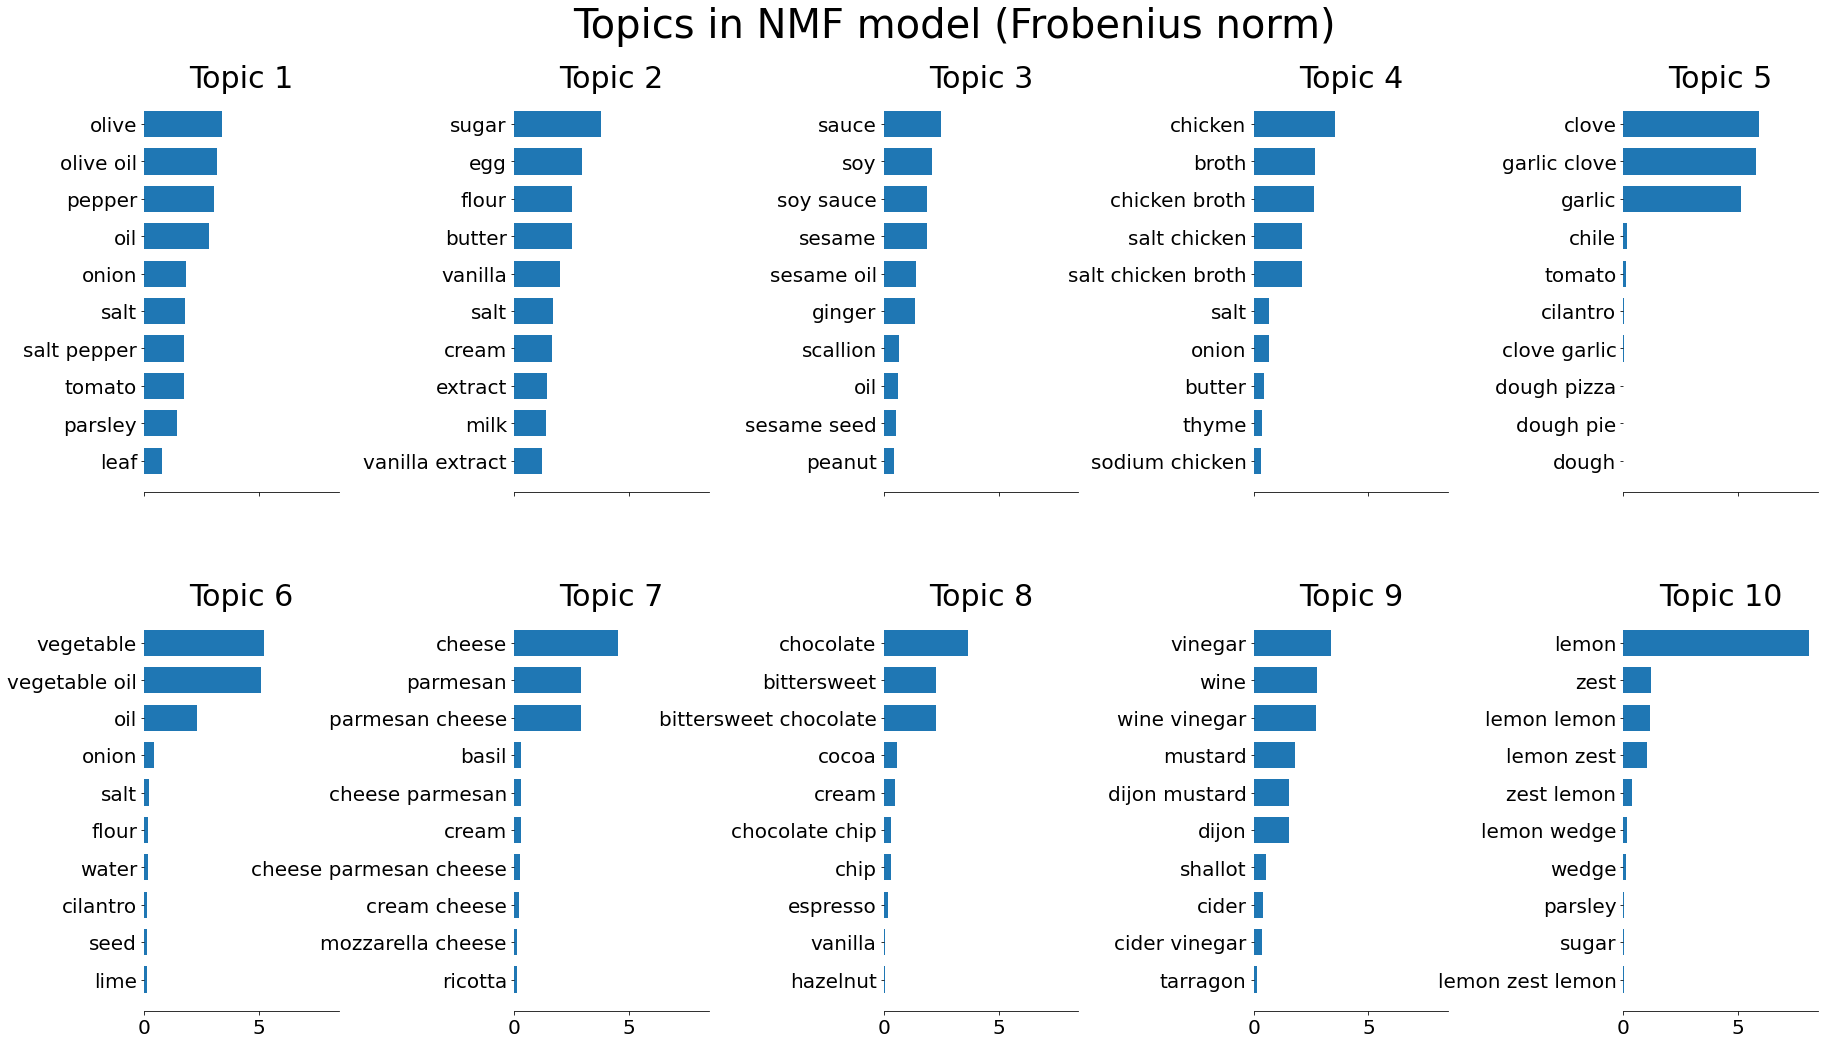

In [18]:
tfidf_feature_names = cv.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [ ]:
X_nmf_df = pd.DataFrame(data=X_nmf, index=X.index)

In [20]:
X_nmf_train, X_nmf_test, y_train, y_test = train_test_split(
        X_nmf, y, random_state=240, stratify=y
    )

In [26]:
X_train

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a4638719925f464b395c16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a441126529d92b2c01b5f2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a409bb19925f464b37380a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a42e1019925f464b3818d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54a436266529d92b2c018767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a466e16529d92b2c026f67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a451cd6529d92b2c01eefd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print(X_nmf_train)

[[0.01133187 0.         0.         ... 0.         0.00566981 0.        ]
 [0.00235935 0.03067397 0.         ... 0.09322058 0.         0.        ]
 [0.00928439 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01192979 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05886551 0.         ... 0.         0.         0.        ]
 [0.         0.05831785 0.         ... 0.         0.         0.01825548]]


In [28]:
def objective(trial):
    cluster_size = trial.suggest_int('min_cluster_size', 10, 200)
    min_samps = trial.suggest_int('min_samples', 5, 60)
    cluster_selection_eps = trial.suggest_float('cluster_selection_epsilon', 0.2, 0.7)

    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_samps, cluster_selection_epsilon=cluster_selection_eps, prediction_data=True)

    hdbscan_labels = hdbscanner.fit_predict(X_nmf_train)

    # DBCV is actually built into HDBSCAN but in the validity class
    # remember this score is from -1 to 1
    hdbscan_score = hdbscan.validity.validity_index(X_nmf_train, hdbscan_labels, metric='euclidean')
    #hdbscan_score = DBCV(X_train.values, hdbscan_labels, dist_function=euclidean)
    
    return hdbscan_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000) #, gc_after_trial=True)
print(study.best_trial)

[I 2022-11-17 23:26:11,762] A new study created in memory with name: no-name-8e1f6e78-e247-401c-851b-303cf6284bb5
[I 2022-11-17 23:26:17,245] Trial 0 finished with value: -0.07511483103975765 and parameters: {'min_cluster_size': 21, 'min_samples': 21, 'cluster_selection_epsilon': 0.6550714929694941}. Best is trial 0 with value: -0.07511483103975765.
[I 2022-11-17 23:26:18,765] Trial 1 finished with value: 0.0829341991566377 and parameters: {'min_cluster_size': 71, 'min_samples': 54, 'cluster_selection_epsilon': 0.47193922643111963}. Best is trial 1 with value: 0.0829341991566377.
[I 2022-11-17 23:26:27,387] Trial 2 finished with value: -0.17470668433969985 and parameters: {'min_cluster_size': 19, 'min_samples': 5, 'cluster_selection_epsilon': 0.2849222103728993}. Best is trial 1 with value: 0.0829341991566377.
[I 2022-11-17 23:26:29,089] Trial 3 finished with value: 0.021098035258289113 and parameters: {'min_cluster_size': 70, 'min_samples': 28, 'cluster_selection_epsilon': 0.432760893

FrozenTrial(number=976, values=[0.3850597671309829], datetime_start=datetime.datetime(2022, 11, 18, 0, 44, 8, 794715), datetime_complete=datetime.datetime(2022, 11, 18, 0, 44, 15, 406765), params={'min_cluster_size': 14, 'min_samples': 57, 'cluster_selection_epsilon': 0.5153781025526232}, distributions={'min_cluster_size': IntDistribution(high=200, log=False, low=10, step=1), 'min_samples': IntDistribution(high=60, log=False, low=5, step=1), 'cluster_selection_epsilon': FloatDistribution(high=0.7, log=False, low=0.2, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=976, state=TrialState.COMPLETE, value=None)


In [34]:
study.best_trial.params

{'min_cluster_size': 14,
 'min_samples': 57,
 'cluster_selection_epsilon': 0.5153781025526232}

In [35]:
study.best_params

{'min_cluster_size': 14,
 'min_samples': 57,
 'cluster_selection_epsilon': 0.5153781025526232}

In [38]:
study.best_params['min_cluster_size']

14

In [66]:
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=study.best_params['min_cluster_size'], min_samples=study.best_params['min_samples'], cluster_selection_epsilon=study.best_params['cluster_selection_epsilon'], prediction_data=True)

hdbscan_X_train_labels = hdbscanner.fit_predict(X_nmf_train)
hdbscan_X_test_labels= hdbscan.approximate_predict(hdbscanner, X_nmf_test)

In [49]:
np.unique(hdbscan_X_train_labels)

array([-1,  0,  1])

In [50]:
hdbscan_X_train_labels

array([ 1, -1,  1, ..., -1,  1,  1])

In [61]:
hdbscanner.labels_

array([-1,  0,  1])

In [53]:
hdbscanner.probabilities_

array([1.        , 0.        , 0.80345464, ..., 0.        , 1.        ,
       0.97405878])

In [63]:
hdbscan.prediction.all_points_membership_vectors(hdbscanner)

array([[0.04762073, 0.06359475, 0.08723512, ..., 0.10575208, 0.13994041,
        0.1318328 ],
       [0.3887856 , 0.06480752, 0.06796418, ..., 0.06799384, 0.07048889,
        0.07476461],
       [0.05324901, 0.0641129 , 0.0809652 , ..., 0.08740883, 0.10388981,
        0.10318631],
       ...,
       [0.05019189, 0.05507058, 0.15954458, ..., 0.0644048 , 0.06759725,
        0.06680872],
       [0.03383916, 0.02673606, 0.03021665, ..., 0.03386854, 0.04022896,
        0.53663445],
       [0.09091266, 0.07980986, 0.08949809, ..., 0.08758645, 0.09540361,
        0.31866998]])

In [65]:
hdbscan_X_train_predicted_labels= hdbscan.approximate_predict(hdbscanner, X_nmf_train)

In [67]:
hdbscan_X_train_predicted_labels

(array([-1, -1, -1, ..., -1,  7, -1], dtype=int32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.76737625,
        0.        ]))

In [51]:
hdbscan_X_test_labels

(array([-1, -1,  0, ..., -1, -1, -1], dtype=int32),
 array([0., 0., 1., ..., 0., 0., 0.]))

In [59]:
np.unique(hdbscan_X_test_labels[0])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int32)

In [62]:
np.unique(hdbscan_X_test_labels[1])

array([0.        , 0.66939743, 0.68052788, 0.68117669, 0.68254831,
       0.68862629, 0.69008571, 0.6933059 , 0.70474244, 0.71049854,
       0.71639551, 0.71840633, 0.72224741, 0.72285587, 0.72347708,
       0.72381101, 0.73051494, 0.73310098, 0.73343029, 0.73506378,
       0.73668866, 0.74311838, 0.74598497, 0.7468142 , 0.7474584 ,
       0.75143066, 0.75844274, 0.765089  , 0.76701813, 0.77082264,
       0.77145817, 0.7720046 , 0.77284394, 0.77684654, 0.78030394,
       0.78623025, 0.78766403, 0.79782276, 0.80034932, 0.8008325 ,
       0.80202837, 0.80489636, 0.81087089, 0.81139768, 0.81701385,
       0.81996314, 0.82112604, 0.82972577, 0.83886961, 0.85199435,
       0.85906933, 0.8630541 , 0.86508043, 0.86585343, 0.8676488 ,
       0.86773399, 0.8687363 , 0.86876576, 0.87679856, 0.88460225,
       0.88893227, 0.89002197, 0.89514202, 0.89757125, 0.89852019,
       0.9018302 , 0.90558618, 0.90632582, 0.91092492, 0.91109167,
       0.91306833, 0.91401077, 0.91621171, 0.91772851, 0.91886

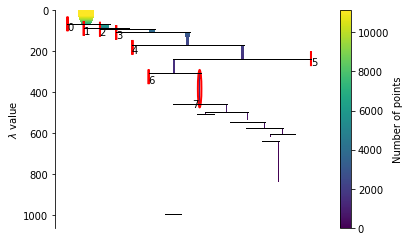

In [57]:
hdbscanner.condensed_tree_.plot(select_clusters=True, label_clusters=True);

In [69]:
X_nmf_train.shape

(11124, 10)

Given that we have HDBSCAN labels, what can we do with this considering we're still in 10 dimensional space

In [74]:
cuisine_hdbscan_labels_train = list(zip(y_train, hdbscan_X_train_predicted_labels[0]))

cuisine_hdbscan_labels_train_df = pd.DataFrame(data=cuisine_hdbscan_labels_train, columns=['cuisine_label', 'hdbscan_label'])

[('French', -1),
 ('Kosher', -1),
 ('Asian', -1),
 ('American', -1),
 ('Southwestern', -1),
 ('Mediterranean', -1),
 ('American', -1),
 ('Latin American', -1),
 ('American', -1),
 ('American', -1),
 ('Mediterranean', 7),
 ('American', -1),
 ('American', -1),
 ('Asian', -1),
 ('Mediterranean', -1),
 ('American', -1),
 ('American', 7),
 ('American', -1),
 ('Italian', 4),
 ('American', -1),
 ('Italian', -1),
 ('Asian', -1),
 ('Mexican', -1),
 ('French', -1),
 ('American', -1),
 ('French', 7),
 ('Mexican', 7),
 ('Middle Eastern', -1),
 ('American', -1),
 ('American', -1),
 ('Cajun/Creole', -1),
 ('Mediterranean', -1),
 ('American', -1),
 ('French', -1),
 ('Mediterranean', -1),
 ('Italian', -1),
 ('French', -1),
 ('Asian', -1),
 ('American', -1),
 ('Italian', -1),
 ('American', -1),
 ('English', 7),
 ('Caribbean', -1),
 ('Mexican', -1),
 ('American', 7),
 ('Asian', -1),
 ('Asian', -1),
 ('American', -1),
 ('American', 7),
 ('Italian', -1),
 ('Middle Eastern', -1),
 ('American', -1),
 ('Amer

In [73]:
cuisine_hdbscan_labels_test = list(zip(y_test, hdbscan_X_test_labels[0]))
cuisine_hdbscan_labels_test

[('American', -1),
 ('Mediterranean', -1),
 ('American', 0),
 ('American', -1),
 ('Scandinavian', -1),
 ('American', -1),
 ('French', -1),
 ('American', -1),
 ('Mexican', -1),
 ('American', -1),
 ('French', -1),
 ('Asian', -1),
 ('American', -1),
 ('French', 7),
 ('Asian', -1),
 ('African', -1),
 ('French', -1),
 ('Mediterranean', -1),
 ('American', -1),
 ('Scandinavian', -1),
 ('American', 7),
 ('French', -1),
 ('Mexican', -1),
 ('American', -1),
 ('French', -1),
 ('Cajun/Creole', -1),
 ('Caribbean', -1),
 ('American', -1),
 ('Italian', -1),
 ('German', -1),
 ('French', -1),
 ('American', -1),
 ('Chinese', -1),
 ('American', 7),
 ('American', -1),
 ('American', -1),
 ('Italian', -1),
 ('American', -1),
 ('Italian', -1),
 ('American', 7),
 ('American', -1),
 ('American', -1),
 ('Indian', -1),
 ('American', -1),
 ('Southwestern', -1),
 ('French', 7),
 ('French', -1),
 ('Vietnamese', 7),
 ('American', -1),
 ('American', -1),
 ('Chinese', -1),
 ('Thai', -1),
 ('American', -1),
 ('Asian', 

What to do now?

1. Can do another dimension reduction to make a 2D visualization after attaching HDBSCAN labels to the original data

Or

1. See how the HDBSCAN labels "map" to cuisine labels
   1. Go back, reattach index labels to data so that you can compare the original recipes with the HDBSCAN labels
2. Predict HDBSCAN labels for the recipes that are missing cuisines and see where they line up (noise, etc)
   1. But also maybe compared to cuisine labels...depending on how many "noisy" recipes there are, this might not be very productive, but see how this looks
3. Could this new HDBSCAN label used instead of a hard mapped cuisine label? What would the results look like?
   1. Gets a little tricky if recipes map to noise
   2. This involves a refactor of MeaLeon's webapp (which is overdue)
4. Can still do 2D visualization to have something up
   1. Mix in the probability to impact "density" of color (like the HDBSCAN plot examples...but in Bokeh)

In [ ]:
wcss = []
for i in range(2, 32):
    clustering = KMeans(n_clusters=i, random_state=200)
    clustering.fit(X_train_transformed)
    wcss.append(clustering.inertia_)

ks = list(range(2,32))

sns.lineplot(x = ks, y = wcss);

This looks like 5 clusters on 5 features

In [ ]:
for i in range(2, 23):

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    # ax1.set_ylim([0, len(to_plot_tsne) + (i + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=i, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(
        "For n_clusters =",
        i,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    # ax2.scatter(
    #     to_plot_tsne['x'], to_plot_tsne['y'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    # )

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for k, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Silhouette analyis still pretty inconclusive...elbow method said around 5, but 5 clusters doesn't look that good in silhouette analysis

## Let's try ~~Truncated SVD~~ Optuna

In [ ]:
# definte objective function to be maximized
def objective(trial):
    clusterer = trial.suggest_categorical()

In [ ]:
wcss = []
for i in range(2, 33):
    clustering = KMeans(n_clusters=i, random_state=200)
    clustering.fit(X_train)
    wcss.append(clustering.inertia_)

ks = list(range(2,33))

sns.lineplot(x = ks, y = wcss);

In [ ]:
X_train_transformed = agglo.transform(X_train)
X_train_transformed.shape

In [ ]:
wcss = []
for i in range(2, 32):
    clustering = KMeans(n_clusters=i, random_state=200)
    clustering.fit(X_train_transformed)
    wcss.append(clustering.inertia_)

ks = list(range(2,32))

sns.lineplot(x = ks, y = wcss);

This kinda looks like 8

In [ ]:
for i in range(2, 33):

    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    # ax1.set_ylim([0, len(to_plot_tsne) + (i + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=i, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train_transformed)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
    print(
        "For n_clusters =",
        i,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_transformed, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    # ax2.scatter(
    #     to_plot_tsne['x'], to_plot_tsne['y'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    # )

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for k, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
